In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload



env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1027 20:50:31.510577 140303216572224 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1027 20:50:31.552203 140303216572224 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

In [3]:
img_filepaths = (data_dir/"train"/"images").ls()
mask_filepaths = [mask_dir / f.name for f in img_filepaths]
img_ids =  [f.name.replace('.png', '') for f in mask_filepaths]
unique_img_ids = list(set(['_'.join(x.split('_')[:2]) for x in img_ids]))

In [4]:
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [5]:
codes = ['background',  'no-damage','minor-damage', 'major-damage', 'destroyed', 'un-classified']
def is_valid_func(fname):
    img_id = '_'.join(Path(fname).name.split('_')[1:3])

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

In [6]:
size=128
bs=16
src = (SegmentationItemList.from_folder(train_images_crops)
       .filter_by_func(lambda fname: '_pre_disaster' in Path(fname).name)
      .split_by_valid_func(is_valid_func)
       .label_from_func(get_mask_fn, classes=codes[:2]))

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


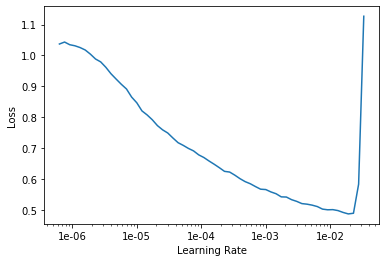

In [10]:
wd =1e-2
metrics = [partial(foreground_acc, void_code=0),fbeta, dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.to_fp16();
learn.lr_find()
learn.recorder.plot(skip_end=1)

In [11]:
lr=1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,fbeta,dice,time
0,0.164856,0.130089,0.533074,0.134878,0.620406,01:14
1,0.136615,0.120910,0.707513,0.125746,0.701406,01:14
2,0.122828,0.104389,0.680037,0.123694,0.721317,01:13
3,0.111883,0.098650,0.704107,0.122636,0.739773,01:14
4,0.110959,0.097255,0.702032,0.121953,0.741960,01:14


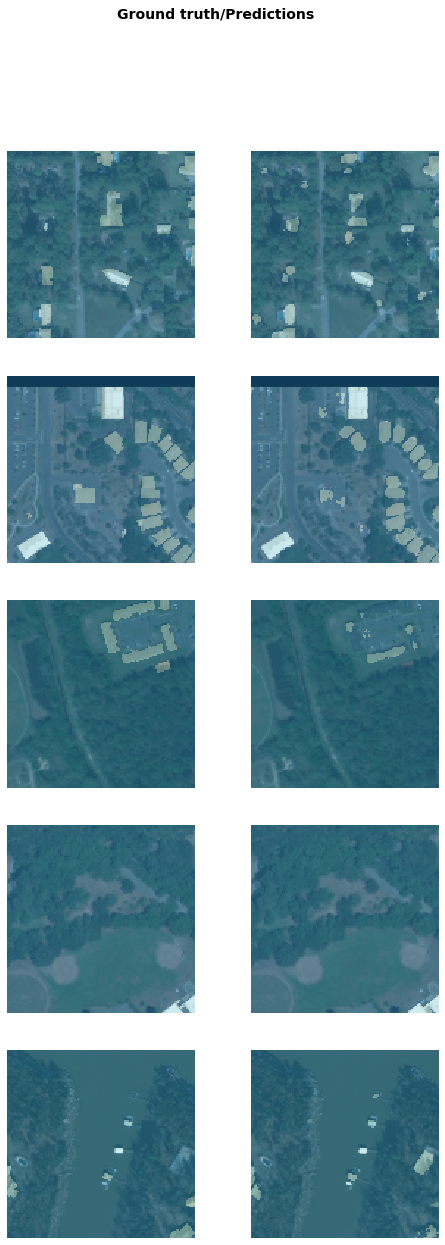

In [12]:
learn.show_results()

In [13]:
learn.save("27Oct_predamaged_model", return_path=True)

PosixPath('/media/wwymak/Storage/xView2/train_crops/models/27Oct_predamaged_model.pth')

In [17]:
gt_mask=(PIL.Image.open(mask_dir/'palu-tsunami_00000024_pre_disaster.png'))
gt_img = PIL.Image.open(data_dir/"train"/"images"/'palu-tsunami_00000024_pre_disaster.png')

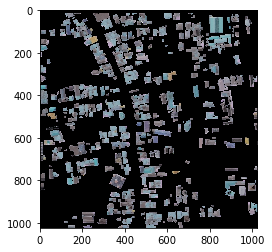

In [25]:
plt.imshow((np.array(gt_mask) * 255)[..., None] *  np.array(gt_img))